<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Recommender systems: Collaborative filtering
© ExploreAI Academy

In this notebook, we will dive into collaborative filtering. Through practical implementation, we'll explore how collaborative filtering leverages user similarity to make personalised recommendations. We'll explore its implementation and compare it with content-based filtering to understand the trade-offs between the two approaches.
## Learning Objectives

By the end of this notebook, you should be able to:
* Gain intuition for the basic operation of collaborative filtering.
* Implement a simple collaborative-based filtering algorithm.


## Outline

This train is structured as follows:
- The intuition behind collaborative-based filtering
- Implementation of collaborative-based filtering

## Collaborative-based Filtering 

### How it works

<br></br>

<div align="center" style="width: 700px; font-size: 80%; text-align: center; margin-left: 80px">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Utility_Matrix.jpg"
     alt="Collaborative-based Filtering - Utility Matrix"
     style="float: center; padding-bottom=0.5em"
     width=700px/>
Utility matrix used to assess the similarity between users who have rated items. 
</div>

In content-based filtering, we looked at the similarity between the properties or attributes of items. In collaborative-based filtering, **we measure the similarity between users to make recommendations**.

To see how this works, consider several individuals who are currently using our collaborative-based recommender system. Simon, Kwanda, Kieran and Joanne have all rated certain books that they've read, and we've been able to capture these results. Using this information, we can construct what is known as a **Utility Matrix**, which (as shown in the figure above) is a structure simply capturing our rating data in a formal way. In the utility matrix, each user is represented as a row$^*$, and the items (books) in our catalogue make up features for each user - whether they have rated a book or not, and what ratings they have given. We note here importantly that this matrix is inherently *sparse*, as there are far more items available in the catalogue than a user's supplied ratings.  

Using the structured information in the utility matrix, we can measure how similar users are to one another based on their rating characteristics. Using our example to help make this point, consider how Joanne and Simon could be considered to be similar as both have read the novels "Pride and Prejudice" and "The Diary of a Young Girl", and have given very similar ratings for both. On the other hand, even though Kwanda has also read and similarly rated "The Diary of a Young Girl", he would still be considered less similar to a user like Simon as they have fewer book reviews in common. 

Using this principle of user similarity, when we seek to make a recommendation for a user based on collaborative filtering, we usually seek to determine the *k-neighbors* who are most similar to the user. From these users, we then extract their highly-rated items and use these as a basis for recommendations. 

One powerful argument of why using user similarity is favourable, compared to that of item similarity, lies in recommendation variety. When looking at our content-based recommendations, we observed that the items suggested tended to be homogeneous; they were all by the same author or genre etc. But humans aren't homogeneous all the time - we like different things in different categories and at different times. As collaborative filtering considers similar individuals, it also considers similarities across categories, allowing recommendations to be more varied and natural.

A major downside to this approach, however, is described by what is known as the **'Cold-start problem'**. Consider, for example, user Kieran, who has just recently joined our recommender service. He has supplied only one rating; he seems to absolutely love "The Hunger Games". The problem is that no one else in our service has rated that book, and Kieran hasn't rated anything else as well. This predicament means that we cannot get a similarity between Kieran and any other user - making our collaborative approach infeasible! While there are various ways of getting around this problem (we see a simple example in our implementation), the Cold-start problem is an ongoing challenge which continues to haunt recommender system researchers. If you feel passionate about this field, perhaps you need to be the person to solve this problem definitively once and for all!

$^*$*Note that this isn't always the case, as it's perfectly acceptable for the utility matrix to have rows representing items and columns representing users. The important thing is that we are mapping ratings from users to items in one form or another.*  

### Dataset Overview

Once again, we will be using the **Book_rating.csv** dataset derived from the [Goodbooks-10k dataset](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/) within this train.

As usua, we can start by importing the libraries we need.

In [1]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficiency. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convenient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
book_ratings = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/unsupervised_sprint/book_ratings.csv')
book_ratings.head()

,user_id,book_id,title,rating
0,314,1,Harry Potter and the Half-Blood Prince (Harry ...,5
1,439,1,Harry Potter and the Half-Blood Prince (Harry ...,3
2,588,1,Harry Potter and the Half-Blood Prince (Harry ...,5
3,1169,1,Harry Potter and the Half-Blood Prince (Harry ...,4
4,1185,1,Harry Potter and the Half-Blood Prince (Harry ...,4


In [3]:
print (f'Number of ratings in dataset: {book_ratings.shape[0]}')

Number of ratings in dataset: 79701


### Implementation 

We now implement a simple collaborative filtering-based recommendation algorithm.

In a similar process to content filtering, where we first had to gather item features before we could compute their similarity, within collaborative filtering, we initially needed to gather all user ratings together by forming a utility matrix.

Using `pandas`, we can construct our utility matrix easily by using the `pivot_table` function:

In [4]:
util_matrix = book_ratings.pivot_table(index=['user_id'], 
                                       columns=['title'],
                                       values='rating') 
util_matrix.shape

(28906, 812)

We previously mentioned that the utility matrix is sparse, as it is unlikely that a user has read many of the books within the entire Goodbooks library. To illustrate this point, let's visualise a portion of the utility matrix: 

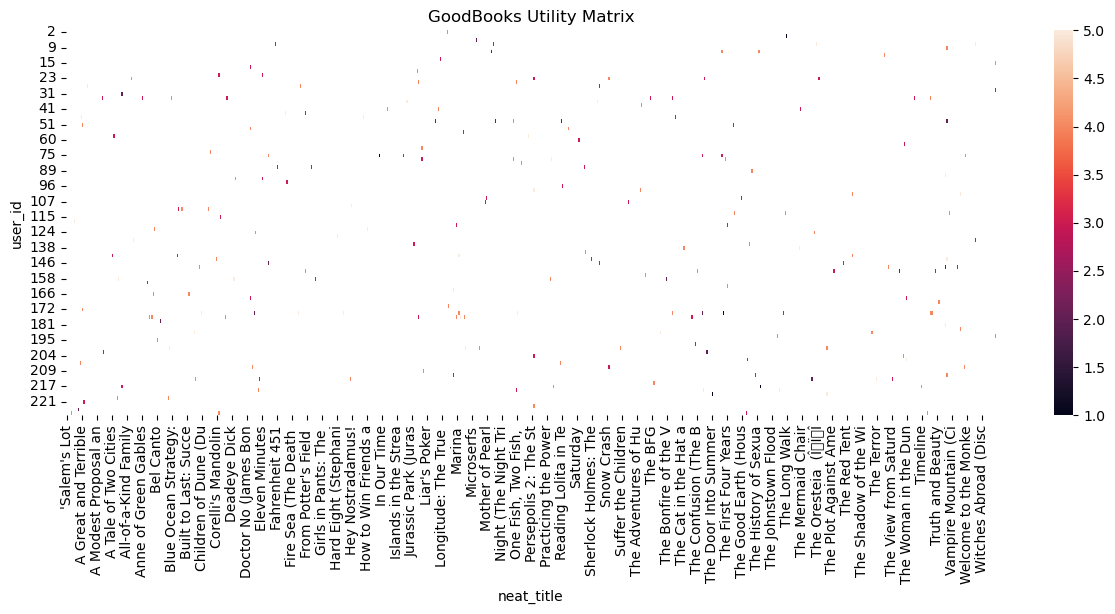

In [5]:
# Create a neat version of the utility matrix to assist with plotting book titles 
book_ratings['neat_title'] = book_ratings['title'].apply(lambda x: x[:20])
util_matrix_neat = book_ratings.pivot_table(index=['user_id'], 
                                            columns=['neat_title'],
                                            values='rating')

fig, ax = plt.subplots(figsize=(15,5))
# We select only the first 100 users for ease of computation and visualisation. 
# You can play around with this value to see more of the utility matrix. 
_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('GoodBooks Utility Matrix')

Note that the white regions of the heatmap indicate cells in the utility matrix for which we have no rating data. 

With our utility matrix created, we now preprocess our data in preparation for similarity computation. This is done by normalising each user's set of ratings, filling in Nan values with 0, [transposing](https://www.khanacademy.org/math/linear-algebra/matrix-transformations/matrix-transpose/v/linear-algebra-transpose-of-a-matrix) our matrix for easier indexing, dropping users with no ratings, and storing the matrix in a sparse representation to save memory.   

In [6]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

We can now compute the similarity between users based on the ratings they have given various books

In [7]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_norm.columns, 
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix  
user_sim_df[:5]

user_id,7,10,23,27,35,41,46,47,49,51,...,53364,53366,53372,53373,53378,53381,53393,53403,53406,53420
user_id,,,,,,,,,,,,,,,,,,,,,
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.177657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With our similarity matrix formed, we are once again in a position to make some recommendations. 

As was the process for content-based filtering, we'll first look at generating top-N recommendations and then rating predictions using collaborative filtering.

#### Top-N Recommendations

In order to produce a list of top-N recommendations for collaborative filtering, the following simple algorithm can be followed: 

  1. Select an initial reference user to generate recommendations for. 
  2. Extract all the similarity values between the reference user and each other user in the similarity matrix.
  3. Sort the resulting similarity values in descending order, and select the $k$ most similar users based on these values.  
  5. For each selected user, collect their top-rated items. 
  6. Form a tally of which items are most popular across the $k$ similar users. Do this by counting how many times a top-rated item is common amongst the other users. 
  7. Sort the top-rated items according to the popularity tally. Return the top-N values as the result. 
    
  
We implement this algorithmic process in the function below:

In [8]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user. 
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalogue. 
    if user not in user_sim_df.columns:
        return book_ratings.groupby('title').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()
    
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users
    
    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())
        
    # Loop over each user's favourite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]: 
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N  

With our algorithm defined, let's go and look at the recommended books for our friend, user 314:

In [9]:
# Our recommended list for user 314
collab_generate_top_N_recommendations(314)

['Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'The Lord of the Rings: Weapons and Warfare',
 "I'm a Stranger Here Myself: Notes on Returning to America after Twenty Years Away",
 'Treasure Island',
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
 'Children of Dune (Dune Chronicles #3)',
 'The Broken Wings',
 'Neither Here nor There: Travels in Europe',
 'The Power of One (The Power of One, #1)']

In [10]:
# User 314's historical ratings
book_ratings[book_ratings['user_id'] == 314][:][['title','rating']].sort_values(by='rating', ascending=False)[:10]

,title,rating
0,Harry Potter and the Half-Blood Prince (Harry ...,5
401,Harry Potter and the Goblet of Fire (Harry Pot...,5
4000,The Door Into Summer,4
300,Harry Potter and the Prisoner of Azkaban (Harr...,4
1600,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4
1900,The Lord of the Rings: Weapons and Warfare,4
7501,Memories of My Melancholy Whores,4
2501,Dune Messiah (Dune Chronicles #2),4
16301,"The Long Goodbye (Philip Marlowe, #6)",3
9501,Deception Point,3


In considering our recommended list and comparing it to that of user 314's actual favourite reads, several things stand out: 

 - First, the list we have generated is far more diverse than those we produced via content-based filtering. Here, we recommend books which feel more similar in genre than, say, the author alone.
 
 
 - Second, there is an overlap between the titles that user 314 has already read and those produced by our list. This is actually understandable, as users who have rated the same content highly will be more similar to the reference user.
 
 
 - Third, our list's recommendations align well with user 314's preferences. Here highly rated books by the user appear in our recommended list. Just as mentioned for content-based filtering, the use of a metric such as the hit-rate could help quantify this good fit. 

#### Rating Prediction

We can generate user-item ratings for collaborative filtering using the following algorithmic steps: 

   1. Select a reference user from the database and a reference item (book) they have _not_ rated. 
   2. For the reference user, gather the similarity values between them and each other user. 
   3. Sort the gathered similarity values in descending order. 
   4. Select the $k$ highest similarity values which are above a given threshold value, creating a collection $K$ similar users. 
   5. For each user in collection $K$, get their rating of the reference item if it exists (other users may not have rated this item as well)
   6. Compute a weighted average rating from both the gathered rating values and user similarity values. This is expressed in the formula as: 
   
   $$ \hat{R}_{ju} = \frac{\sum_{n \in K} s_{nu} \times r_{nj}}{\sum_{n \in K} s_{nu}}   $$
   
   Where $\hat{R}_{ju}$ is the weighted average computed for the reference item $j$ and reference user $u$, $K$ is the collection of similar users, $s_{nu}$ is the similarity computed between users $n$ and $u$, and $r_{nj}$ is the known rating user $n$ has given item $j$.
   7. We return the weighted average $\hat{R}_{ju}$ as the prediction for our reference item.
   
   
We implement this algorithmic process in the function below:

In [11]:
def collab_generate_rating_estimate(book_title, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values 
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user
    
    # Create a weighted sum for each of the k users who have rated the 
    # reference item (book).
    for sim_idx, user_id in enumerate(sim_users):
        # User's rating of the item
        rating = util_matrix.loc[user_id, book_title]
        # User's similarity to the reference user 
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to 
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list) 
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average 
        # rating given by all users for the item.  
        predicted_rating = np.mean(util_matrix[book_title])
    return predicted_rating

Once again we can use our newly formed function to generate rating predictions for user 314.

We start with some known ratings:

In [12]:
title = "The Lord of the Rings: Weapons and Warfare"
actual_rating = book_ratings[(book_ratings['user_id'] == 314) & (book_ratings['title'] == title)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(book_title = title, user = 314)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - The Lord of the Rings: Weapons and Warfare
---
Actual rating: 		 4
Predicted rating: 	 4.432698712267664


In [13]:
title = "Harry Potter and the Goblet of Fire (Harry Potter, #4)"
actual_rating = book_ratings[(book_ratings['user_id'] == 314) & (book_ratings['title'] == title)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(book_title = title, user = 314)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Harry Potter and the Goblet of Fire (Harry Potter, #4)
---
Actual rating: 		 5
Predicted rating: 	 4.913809586979023


And also two unknown ratings:

In [14]:
title = "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)"
pred_rating = collab_generate_rating_estimate(book_title = title, user = 314)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)
---
Actual rating: 		 ?
Predicted rating: 	 4.02995810161615


In [15]:
title = "Treasure Island"
pred_rating = collab_generate_rating_estimate(book_title = title, user = 314)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - Treasure Island
---
Actual rating: 		 ?
Predicted rating: 	 4.571645507538802


Once again, we seem to have derived some very strong results, with our predictions being very close to that of user 314's historical ratings. While again we cannot make any pronouncements on the unseen rating predictions, these values seem to make sense and align with ratings the user has given similar books. 

That's it for collaborative filtering!

___
### Metric comparison: Student exercise
Within the above sections, we implemented functions to predict item (book) ratings using both collaborative and content filtering. Using an appropriate performance metric such as RMSE or MAE, determine which of these two methods is more appropriate for the GoodBooks dataset. You could do this by:
* Divide the book_ratings dataframe into a train and test subset using random sampling. Ensure that the train set is 90 - 95% of the total data.
* Computing similarity matrices using the data available in the train set (this will mainly affect collaborative filtering)
* For each user-item rating in the test set, generate a rating prediction.
* Use the historical rating data in the test set to quantify the performance of each technique.

Once you've computed these results, consider how you could improve either method to be more competitive. How feasible are these changes?
___


### Other considerations 

Here are a couple more things to take into account when implementing these methods:

 - **Diversity of suggestions**: As has already been observed within this train, the diversity of recommendations offered by a recommender algorithm are important. In this sense, collaborative filtering is often considered to produce superior results over content-based filtering.  
 
 
 - **Computational requirements**: While we've used simple examples to illustrate the implementation of collaborative and content-based filtering, you should not overlook considerations for the type of computational resources these methods rely upon. In this sense, both methods require the computation of similarity structures when making recommendations. For content-based filtering, this similarity structure tends to be smaller compared to its collaborative counterpart, as large recommendation services tend to have far more users than items in their databases. The storage of these similarity matrices can take up considerable space. Furthermore, the properties of items remain quite static, meaning that once the item similarity matrix is computed, it can be reused indefinitely (until more properties are used for similarity computation). On the other hand, as user ratings are added to at a constant rate, the utility matrix and, subsequently, the user similarity matrix need to be updated regularly to ensure appropriate recommendations are produced.         
  
  
 - **Sparsity issues**: We've briefly mentioned the Cold-start problem before within this train. To reiterate the point, due to the sparse nature of the utility matrix, it can often become very difficult to make recommendations for users who have few or no ratings captured. However, as time increases, systems that make use of collaborative filtering techniques get progressively better as they passively acquire richer rating data.  
 
 
 - **Hybrid approaches**: In light of the points raised above, one may wonder if there is a 'best of both worlds' approach for recommendation systems which overcomes the limitations of each method. The short is that there is, and this consists of hybrid content-collaborative filtering systems. These are hot research topics at the moment, with all major tech companies such as Google, Netflix, Facebook, and Amazon refining such hybrid approaches.

## Conclusion

Phew! We've covered a lot of ground. Hopefully, at this point, the ideas behind recommender systems and why they are so economically and socially important are a bit less mystical to us. In this train, we explored the use of collaborative filtering within recommender systems and the theory behind this method. Lastly, we used the results obtained in our implementation step to discuss some trade-offs offered between content and collaborative filtering.

## Appendix 
Links to additional resources to help with the understanding of concepts presented in the train:
- [Overview of Collaborative Filtering](https://youtu.be/h9gpufJFF-0)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>